In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [98]:
pd.set_option('display.width', 220)
pd.set_option('display.max_colwidth', 30)

# ***Orders data***

In this section I will check:

* At what time clients create orders with more frequency

* The evolution of orders in the date available

* The distribution of the number of products per order

* Unique clients vs recurrent clients

* Find the most bought items (and relate the variant_id with the product_name, price, etc( inventory data))

* Make a market basket analysis to discover products bought together

In [99]:
orders_path = '/home/alex/zriveAM/zrive-ds/aws/data/orders.parquet'
orders_df = pd.read_parquet(orders_path)
print(orders_df.head(5))

               id                        user_id          created_at order_date  user_order_seq                  ordered_items
10  2204073066628  62e271062eb827e411bd739411... 2020-04-30 14:32:19 2020-04-30               1  [33618849693828, 336188601...
20  2204707520644  bf591c887c46d5d3513142b6a8... 2020-04-30 17:39:00 2020-04-30               1  [33618835243140, 336188359...
21  2204838822020  329f08c66abb51f8c0b8a95266... 2020-04-30 18:12:30 2020-04-30               1  [33618891145348, 336188935...
34  2208967852164  f6451fce7b1c58d0effbe37fcb... 2020-05-01 19:44:11 2020-05-01               1  [33618830196868, 336188465...
49  2215889436804  68e872ff888303bff58ec56a3a... 2020-05-03 21:56:14 2020-05-03               1  [33667166699652, 336671666...


In [163]:
print("Dataframe shape:",orders_df.shape)
print("----------------------------------")
print("Dataframe info:")
print(orders_df.info())

Dataframe shape: (8773, 8)
----------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       8773 non-null   int64         
 1   user_id                  8773 non-null   object        
 2   created_at               8773 non-null   datetime64[us]
 3   created_at_hour          8773 non-null   int32         
 4   order_date               8773 non-null   datetime64[us]
 5   user_order_seq           8773 non-null   int64         
 6   ordered_items            8773 non-null   object        
 7   number_of_ordered_items  8773 non-null   int64         
dtypes: datetime64[us](2), int32(1), int64(3), object(2)
memory usage: 582.6+ KB
None


               id                        user_id          created_at order_date  user_order_seq                  ordered_items  created_at_hour
10  2204073066628  62e271062eb827e411bd739411... 2020-04-30 14:32:19 2020-04-30               1  [33618849693828, 336188601...               14
20  2204707520644  bf591c887c46d5d3513142b6a8... 2020-04-30 17:39:00 2020-04-30               1  [33618835243140, 336188359...               17
21  2204838822020  329f08c66abb51f8c0b8a95266... 2020-04-30 18:12:30 2020-04-30               1  [33618891145348, 336188935...               18
34  2208967852164  f6451fce7b1c58d0effbe37fcb... 2020-05-01 19:44:11 2020-05-01               1  [33618830196868, 336188465...               19
49  2215889436804  68e872ff888303bff58ec56a3a... 2020-05-03 21:56:14 2020-05-03               1  [33667166699652, 336671666...               21


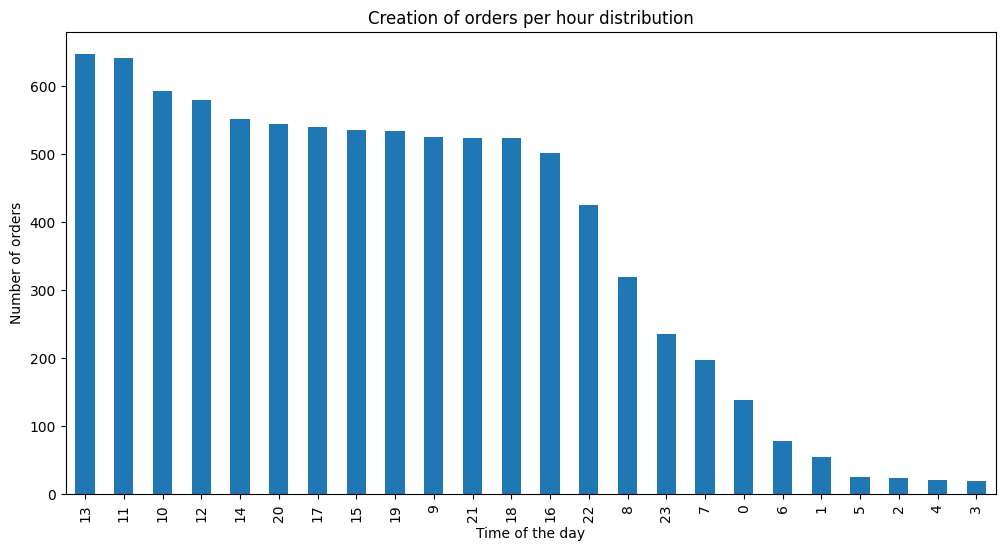

In [101]:
#column with the hour of creation of the order
orders_df['created_at_hour']=orders_df['created_at'].dt.hour
print(orders_df.head())

orders_per_hour=orders_df['created_at_hour'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,6))
orders_per_hour.plot(kind='bar')
plt.title('Creation of orders per hour distribution')
plt.xlabel('Time of the day')
plt.ylabel('Number of orders')
plt.show()



We can push notifications at these hours to maximize creating orders

Orders evolution


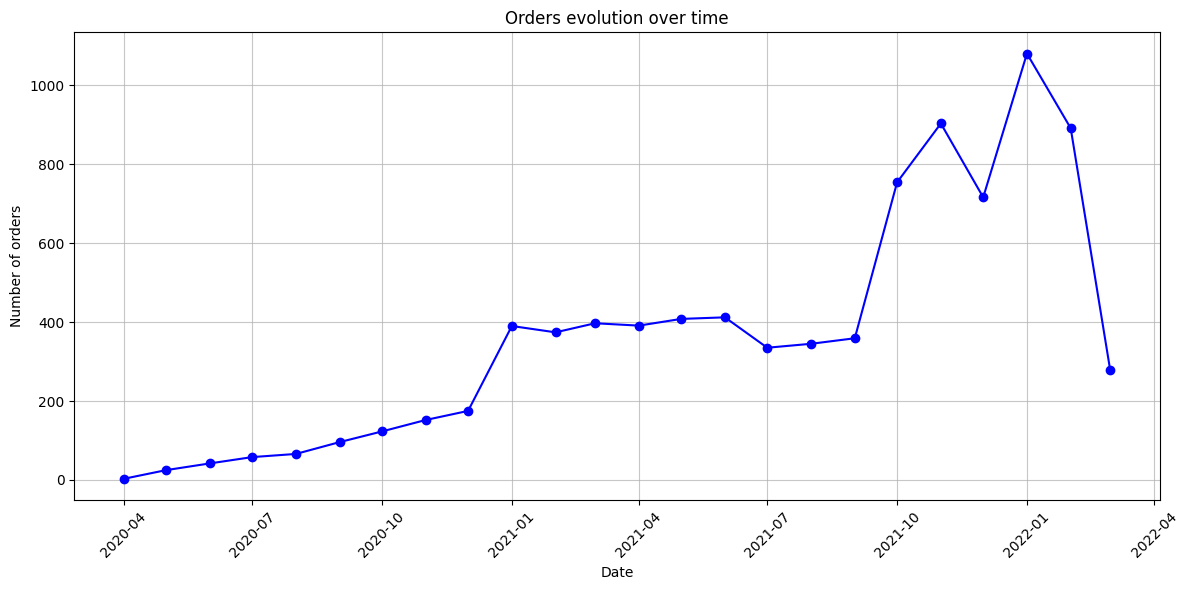

In [102]:
#evolution of orders in the last years

print("Orders evolution")

orders_by_month = orders_df.groupby(orders_df['order_date'].dt.to_period('M')).size()
orders_by_month.index = orders_by_month.index.to_timestamp()

plt.figure(figsize=(12,6))
plt.plot(orders_by_month.index, orders_by_month.values, marker='o', linestyle='-', color='b')
plt.title('Orders evolution over time')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.grid(True, alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [103]:
#Let's create a new column with the nbumber of items per order
orders_df['number_of_ordered_items'] = orders_df['ordered_items'].apply(len)
orders_df=orders_df[['id','user_id','created_at', 'created_at_hour','order_date','user_order_seq','ordered_items','number_of_ordered_items']]
orders_df.head()

,id,user_id,created_at,created_at_hour,order_date,user_order_seq,ordered_items,number_of_ordered_items
10,2204073066628,62e271062eb827e411bd739411...,2020-04-30 14:32:19,14,2020-04-30,1,"[33618849693828, 336188601...",14
20,2204707520644,bf591c887c46d5d3513142b6a8...,2020-04-30 17:39:00,17,2020-04-30,1,"[33618835243140, 336188359...",25
21,2204838822020,329f08c66abb51f8c0b8a95266...,2020-04-30 18:12:30,18,2020-04-30,1,"[33618891145348, 336188935...",15
34,2208967852164,f6451fce7b1c58d0effbe37fcb...,2020-05-01 19:44:11,19,2020-05-01,1,"[33618830196868, 336188465...",10
49,2215889436804,68e872ff888303bff58ec56a3a...,2020-05-03 21:56:14,21,2020-05-03,1,"[33667166699652, 336671666...",10


count    8773.000000
mean       12.305711
std         6.839507
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       114.000000
Name: number_of_ordered_items, dtype: float64


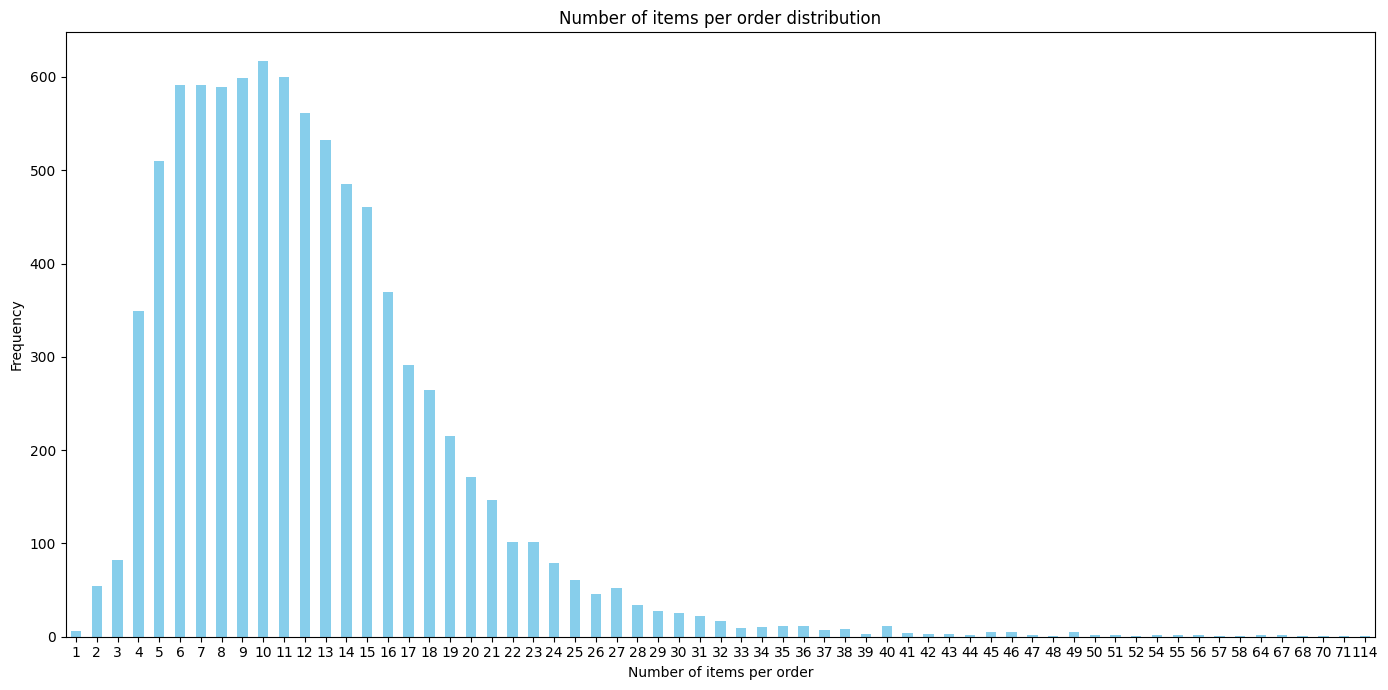

In [104]:
#numer_of_ordereds_items distribution
summary = orders_df['number_of_ordered_items'].describe()
print(summary)


item_counts = orders_df['number_of_ordered_items'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
item_counts.plot(kind='bar', color='skyblue')
plt.title('Number of items per order distribution')
plt.xlabel('Number of items per order')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(False)
plt.tight_layout()
plt.show()

In [105]:
#Unique clients
unique_clients=orders_df['user_id'].value_counts()
print(unique_clients)

user_id
ba7176c5f870cd86e51ecc4375e0becc8cc305845e70b9384ba0d4d156c6099ec96602b15420cb1ff69b6b9adcf9249d09489d511565531c4e928a92157b16d6    25
114e78a8909ad3f9d481e66563998301eff9e7cd1b2d002b77ffc26619f0ef7a6e877d5b3460e0e0bde2d7c67787c66d7384ccf34b4aa4fa1409e978cf47e670    22
04e9d7967f4dfd7d40175f130f1c80f62204ff697df92dfd83407ace7997b6744b6a7cab0382e60f7264b13ba3f03c64f016ae9dca664885ace6020aba3b5131    22
1296e1e72f7f43ff28d7d285f880ad4d213fa8139233c78ad2673af4cc0c1c297180254da494cc3b934858347822be437eeb072acb1403e9476dc0b2f6a83cbe    21
a655b992a3ee5f6aa9f5ab5662c4befac1fdc45c99885b173618b661ca7381c383b1364e977c9f51366cdc62e4d92ff383e8e5aac7ea9a552059be2671de24e2    21
                                                                                                                                    ..
720193c88605b61f880b340ca9a02c673241a37ff74f7d20639fc933ed5438a3b96076b85f168231d34779994c26810adbb24e0d842639837780649a4baf16a8     1
76f2a192182b2d88816355ac40307d4323c6d62da2a27d9

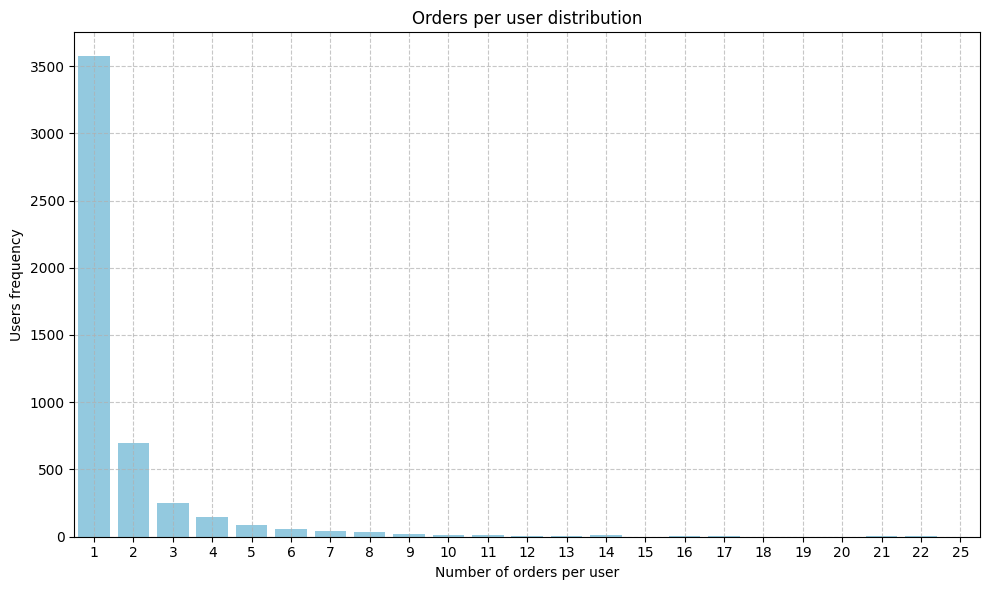

In [106]:
plt.figure(figsize=(10, 6))
value_counts_unique_clients=unique_clients.value_counts().sort_index()
sns.barplot(x=value_counts_unique_clients.index, y=value_counts_unique_clients.values, color='skyblue')

plt.title('Orders per user distribution')
plt.xlabel('Number of orders per user')
plt.ylabel('Users frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Users with 1 order: 3572
Users with more than 1 order: 1411


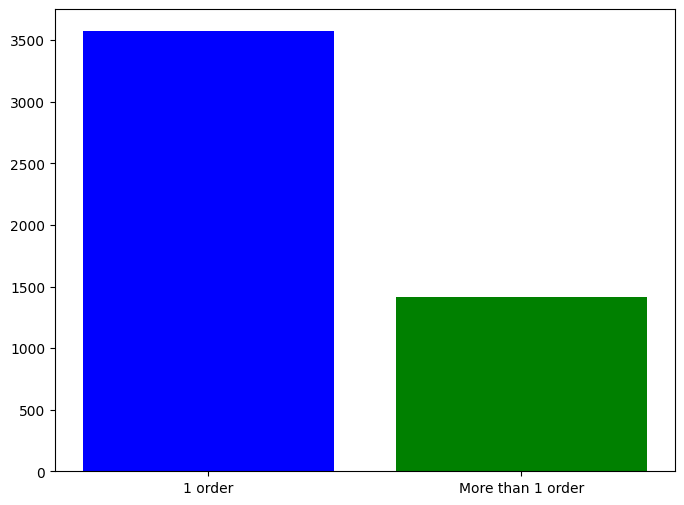

Clients that repeated buying in our platform: 28.316275336142887 %


In [107]:
num_users_with_1_order = (unique_clients == 1).sum()
print(f'Users with 1 order: {num_users_with_1_order}')
num_users_with_more_than_1_order = (unique_clients > 1).sum()
print(f"Users with more than 1 order: {num_users_with_more_than_1_order}")
categories= ['1 order', 'More than 1 order']
counts=[num_users_with_1_order, num_users_with_more_than_1_order]

plt.figure(figsize=(8,6))
plt.bar(categories, counts, color=['blue', 'green'])
plt.tight_layout
plt.show()

percentage_clients_repeat= num_users_with_more_than_1_order / (num_users_with_more_than_1_order + num_users_with_1_order)
print(f"Clients that repeated buying in our platform: {percentage_clients_repeat*100} %")

In [108]:
#Lets' examine the items in the orders

all_products = [product for sublist in orders_df['ordered_items'] for product in sublist]
print(type(all_products))

product_series = pd.Series(all_products)
print(product_series.dtype)
product_counts = product_series.value_counts().reset_index()
product_counts.columns = ['variant_id', 'Frequency']
product_counts = product_counts.sort_values(by='Frequency', ascending=False)
print(product_counts.head())

<class 'list'>
int64
       variant_id  Frequency
0  34081589887108       4487
1  39284117930116       2658
2  34137590366340       1459
3  34081331970180       1170
4  34284951863428       1133


/tmp/ipykernel_1176/1405062628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


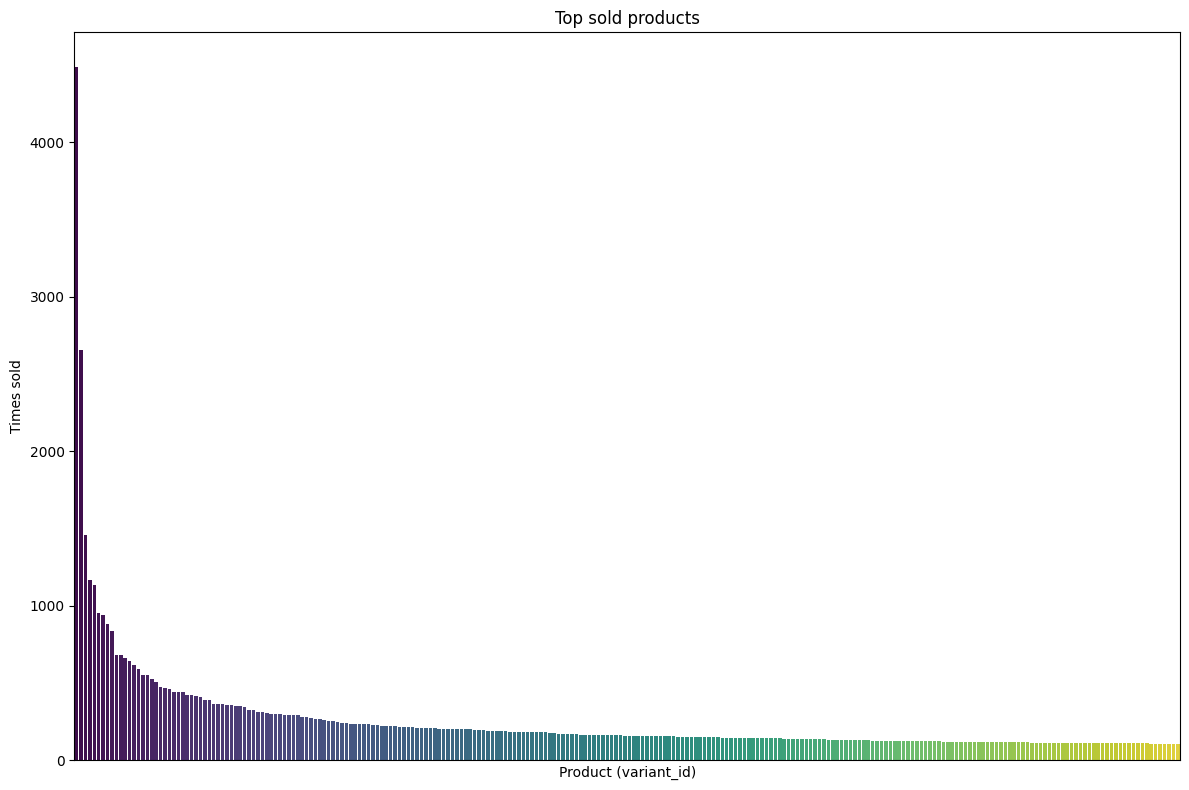

In [109]:
top_products = product_counts.head(250)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='variant_id', 
    y='Frequency', 
    data=top_products, 
    palette='viridis',
    order=top_products['variant_id']
)


plt.title('Top sold products')
plt.xlabel('Product (variant_id)')
plt.ylabel('Times sold')
plt.xticks([])
plt.tight_layout()
plt.show()

In [110]:
#join the df with the products with the inventory data
inventory_path = '/home/alex/zriveAM/zrive-ds/aws/data/inventory.parquet'
inventory_df = pd.read_parquet(inventory_path)
print(inventory_df.shape)
inventory_df.head()

(1733, 6)


,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-t...,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-t...,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-t...,"[b-corp, cruelty-free, eco..."
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [111]:
print(product_counts.shape)

(2117, 2)


In the inventory df we have 1733 variant_ids (products), while in the one extracted from the orders we have 2117 ids

In [112]:
#Complete product_counts dataframe with information from inventory
combined_df = pd.merge(
    product_counts,          
    inventory_df,           
    on='variant_id',         
    how='left'              
)

combined_df.head()

,variant_id,Frequency,price,compare_at_price,vendor,product_type,tags
0,34081589887108,4487,10.79,11.94,oatly,long-life-milk-substitutes,"[oat-milk, vegan]"
1,39284117930116,2658,NaN,NaN,NaN,NaN,NaN
2,34137590366340,1459,NaN,NaN,NaN,NaN,NaN
3,34081331970180,1170,NaN,NaN,NaN,NaN,NaN
4,34284951863428,1133,3.69,3.99,plenty,toilet-roll-kitchen-roll-t...,[kitchen-roll]


At this point we should guess why there are missing variant_ids, we should inform to our team and update data

In [113]:
#let's try a market basket analysis to discover products bought together
from mlxtend.preprocessing import TransactionEncoder

transactions= orders_df['ordered_items'].tolist()
te=TransactionEncoder()
te_ary=te.fit(transactions).transform(transactions)

orders_df_encoded=pd.DataFrame(te_ary, columns=te.columns_)
#print(orders_df_encoded)

from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(orders_df_encoded, min_support=0.02, use_colnames=True)
print(frequent_itemsets.head())
print('--------------------------------------')

from mlxtend.frequent_patterns import association_rules
num_itemsets = len(frequent_itemsets)
rules= association_rules(frequent_itemsets, metric='lift', min_threshold=1.0, num_itemsets=num_itemsets)
print(rules)
print('--------------------------------------')
filtered_rules = rules[['antecedents','consequents','support','confidence','lift']].copy()
variant_id_to_product_type= inventory_df.set_index('variant_id')['product_type'].to_dict()
def replace_variant_with_product_type(itemset, mapping):
    return frozenset({mapping.get(int(item), item) for item in itemset})

filtered_rules['antecedents'] = filtered_rules['antecedents'].apply(lambda x: replace_variant_with_product_type(x, variant_id_to_product_type))
filtered_rules['consequents'] = filtered_rules['consequents'].apply(lambda x: replace_variant_with_product_type(x, variant_id_to_product_type))
print(filtered_rules)

    support          itemsets
0  0.023823  (33667185279108)
1  0.025647  (33667206283396)
2  0.047874  (33667207266436)
3  0.035564  (33667222798468)
4  0.020062  (33667247276164)
--------------------------------------
        antecedents       consequents  antecedent support  consequent support   support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
0  (34284949766276)  (39284117930116)            0.070329            0.302975  0.024507    0.348460  1.150129               1.0  0.003199    1.069812       0.140407  0.070261   0.065256    0.214674
1  (39284117930116)  (34284949766276)            0.302975            0.070329  0.024507    0.080888  1.150129               1.0  0.003199    1.011488       0.187270  0.070261   0.011357    0.214674
2  (39284117930116)  (34284950356100)            0.302975            0.063946  0.029180    0.096313  1.506157               1.0  0.009806    1.035816       0.482133  0.086399   0.034578  

In this case, the Rule 0 says that if someone buy product 34284949766276, there is a 34.85% probability to also buy 39284117930116.
We can use this information to create recommendations or special offers. As we can see, not having the information about variant_ids is something that will slow down all the process

### Problems & rework

* The principal problem is that we have variant_ids shown in this dataset that are not registered in the inventory

* We could also extract some information with the created_at and order_date columns

# ***Regulars data***

* Include info about each variant_id

* Find popular regular items

* Find users that added more regular items (we can identify the most interested and active clients)

In [114]:
regulars_path = '/home/alex/zriveAM/zrive-ds/aws/data/regulars.parquet'
regulars_df = pd.read_parquet(regulars_path)
regulars_df.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b9...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b9...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31...,33667247341700,2020-05-06 14:42:11


In [162]:
print("Dataframe shape:", regulars_df.shape)
print("----------------------------------")
print("Dataframe info:")
print(regulars_df.info())


Dataframe shape: (18105, 3)
----------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB
None


In [116]:
#use dictionary to include product_name of variant_id
regulars_combined_df = pd.merge(
    regulars_df,          
    inventory_df,           
    on='variant_id',         
    how='left'              
)

regulars_combined_df.head()

,user_id,variant_id,created_at,price,compare_at_price,vendor,product_type,tags
0,68e872ff888303bff58ec56a3a...,33618848088196,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
1,aed88fc0b004270a62ff1fe4b9...,33667178659972,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
2,68e872ff888303bff58ec56a3a...,33619009208452,2020-04-30 15:07:03,NaN,NaN,NaN,NaN,NaN
3,aed88fc0b004270a62ff1fe4b9...,33667305373828,2020-05-05 23:34:35,NaN,NaN,NaN,NaN,NaN
4,4594e99557113d5a1c5b59bf31...,33667247341700,2020-05-06 14:42:11,3.49,3.5,method,cleaning-products,"[cruelty-free, eco, vegan,..."


In [117]:
regulars_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18105 entries, 0 to 18104
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           18105 non-null  object        
 1   variant_id        18105 non-null  int64         
 2   created_at        18105 non-null  datetime64[us]
 3   price             15034 non-null  float64       
 4   compare_at_price  15034 non-null  float64       
 5   vendor            15034 non-null  object        
 6   product_type      15034 non-null  object        
 7   tags              15034 non-null  object        
dtypes: datetime64[us](1), float64(2), int64(1), object(4)
memory usage: 1.1+ MB


In [118]:
len(regulars_df['variant_id'].value_counts())

1843

In [119]:
len(inventory_df['variant_id'].value_counts())

1733

We have 110 (1843 - 1733) products without information (price, compare_at_price, vendor, product_type and tags)

In [120]:
#find the product (variant_id) more requested
requested_products = regulars_df['variant_id'].value_counts().reset_index()
requested_products.columns=['variant_id', 'request_count']
requested_products.head()

,variant_id,request_count
0,34081589887108,253
1,34370361229444,127
2,33973249081476,114
3,34370915041412,112
4,34284951863428,105


In [121]:
#users that specified more items
users_activity= regulars_df['user_id'].value_counts().reset_index()
users_activity.columns=['user_id', 'number_of_regular_products']
users_activity.head()

,user_id,number_of_regular_products
0,a124c8bb0453ea0957405b7a08...,726
1,ba068a3398230c10a98868ced1...,499
2,9b5b3679033da9e1f3a4def186...,405
3,257be7ae940425880bbb20bf16...,389
4,9a4b53affbe91ca5fd0c97f6d8...,372


In [122]:
#find repeated users-product combination
recurrent_purchases = regulars_df.groupby(['user_id', 'variant_id']).size().reset_index(name='purchase_count')
pd.set_option('display.max_colwidth', 150)
print(len(recurrent_purchases))
print(recurrent_purchases)
print(len(recurrent_purchases[recurrent_purchases['purchase_count'] == 1]))
print(len(recurrent_purchases[recurrent_purchases['purchase_count'] > 1]))


12365
                                                                                                                                user_id      variant_id  purchase_count
0      004b3e3cb9a9f5b0974ce4179db394057c72e7a82077bfe6a28af9e6306ebc51b0d8c5c8bd4c9b59ebb3237827df723745c1374d12ad2053e0131edc184df17d  33667274997892               1
1      005743eefffa4ce840608c4f47b8c548b134d89be5c39020ea20c4e708544b2dbd94e4b662b34c7c8b2ba1557a54454e45a7349bd7c024d9f5def354d3f38c53  34081589887108               1
2      005743eefffa4ce840608c4f47b8c548b134d89be5c39020ea20c4e708544b2dbd94e4b662b34c7c8b2ba1557a54454e45a7349bd7c024d9f5def354d3f38c53  34519123951748               1
3      0074992079c1836c6509eec748a973dc97388b4877e770f57a3dc05917641897fd65ed9ab35168ce32f7c428c3e048206e12a653f40d48d7eb7db3570b4521b4  33667222896772               1
4      0074992079c1836c6509eec748a973dc97388b4877e770f57a3dc05917641897fd65ed9ab35168ce32f7c428c3e048206e12a653f40d48d7eb7db3570b4521b4  33667247014020   

According to the information above, there are some users (2399) that added the same product multiple times, this could give rise to confusion, because at the end it's only 1 product

In [123]:

user_id_filter = "fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527"
variant_id_filter = 39590266536068

filtered_rows = regulars_df[
    (regulars_df['user_id'] == user_id_filter) & 
    (regulars_df['variant_id'] == variant_id_filter)
]


print(filtered_rows)

                                                                                                                                user_id      variant_id          created_at
31448  fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2022-01-20 09:27:43
23129  fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2021-10-28 13:23:35
33286  fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2022-02-04 10:56:52
31458  fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527  39590266536068 2022-01-20 09:39:11


This could mean that he specified to buy regularly the product in a list and afterwards delete, and repeated the process (?)

### Problems & rework

* As in the previous orders analysis, the principal problem is that we have variant_ids shown in this dataset that are not registered in the inventory

# ***Abandoned_carts data***

* Find most frequent items in abandoned carts (and distribution)

* Find users with most abandoned_carts

* Find days with most abandoned_carts

In [124]:
abdandoned_carts_path = '/home/alex/zriveAM/zrive-ds/aws/data/abandoned_carts.parquet'
abandoned_carts_df = pd.read_parquet(abdandoned_carts_path)
abandoned_carts_df.head()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b4130557c2e49c1193921975a2116d57fefbf911523ce44b6b6e0f8acbf598b36d0e4fc2727ec89378a,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 33667192127620, 33826412331140, 33826472558724, 33826427240580, 33826474590340, 33826457157764, 33667198976132, 3..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd2fb2c4c9ab335534542fecf99d201921dece1889ed054e5b5e8cd87a564815c04b07f6f53ee96861fc,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 34502822363268, 33719435722884, 33803537973380, 39459279929476, 34284955304068, 34284952813700, 39542989619332]"
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b432bca5c2bad4fb803f6c24f90edb0dcb6e64d5791b9bfa389a738b7bad0f2cb19a5f6e4c4ae931009,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 34113606090884, 34284952584324, 34221708673156, 39336624193668, 33667247145092, 39403031167108, 33951139135620, 3..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b812808423874f43384ffdbfb574e3ccc11706aece4f1329b4365fe5bce1a01827d382852daedaf18a2e22fcb8,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 34436055203972, 39403032117380, 33667207266436, 34284951273604, 34284951240836, 39403031691396, 39418337591428, 3..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153a40c83cfa13aa8faebe1d7a2835a2e9c5120b806bc789704622081a413af5c418297da0516c892d756,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


In [164]:
print("Dataframe shape:", abandoned_carts_df.shape)
print("----------------------------------")
print("Dataframe info:")
print(abandoned_carts_df.info())


Dataframe shape: (5457, 6)
----------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           5457 non-null   int64         
 1   user_id      5457 non-null   object        
 2   created_at   5457 non-null   datetime64[us]
 3   variant_id   5457 non-null   object        
 4   day_of_week  5457 non-null   object        
 5   hour_of_day  5457 non-null   int32         
dtypes: datetime64[us](1), int32(1), int64(1), object(3)
memory usage: 277.1+ KB
None


In [153]:
#most frequent items in abandoned_carts
all_abandoned_products = [product for sublist in abandoned_carts_df['variant_id'] for product in sublist]
print(type(all_abandoned_products))

abandoned_product_series = pd.Series(all_abandoned_products)
print(abandoned_product_series.dtype)
abandoned_product_counts = abandoned_product_series.value_counts().reset_index()
abandoned_product_counts.columns = ['variant_id', 'Frequency']
abandoned_product_counts = abandoned_product_counts.sort_values(by='Frequency', ascending=False)
print(abandoned_product_counts.head(15))

<class 'list'>
int64
        variant_id  Frequency
0   34081589887108        608
1   34284951863428        478
2   34284950356100        409
3   34137590366340        395
4   34284949766276        382
5   34284950519940        307
6   34284950454404        306
7   39459279929476        305
8   39284117930116        298
9   34037939372164        290
10  39709997760644        277
11  39405098369156        256
12  34370361229444        253
13  34543001370756        242
14  34543001337988        241


/tmp/ipykernel_1176/1903424935.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


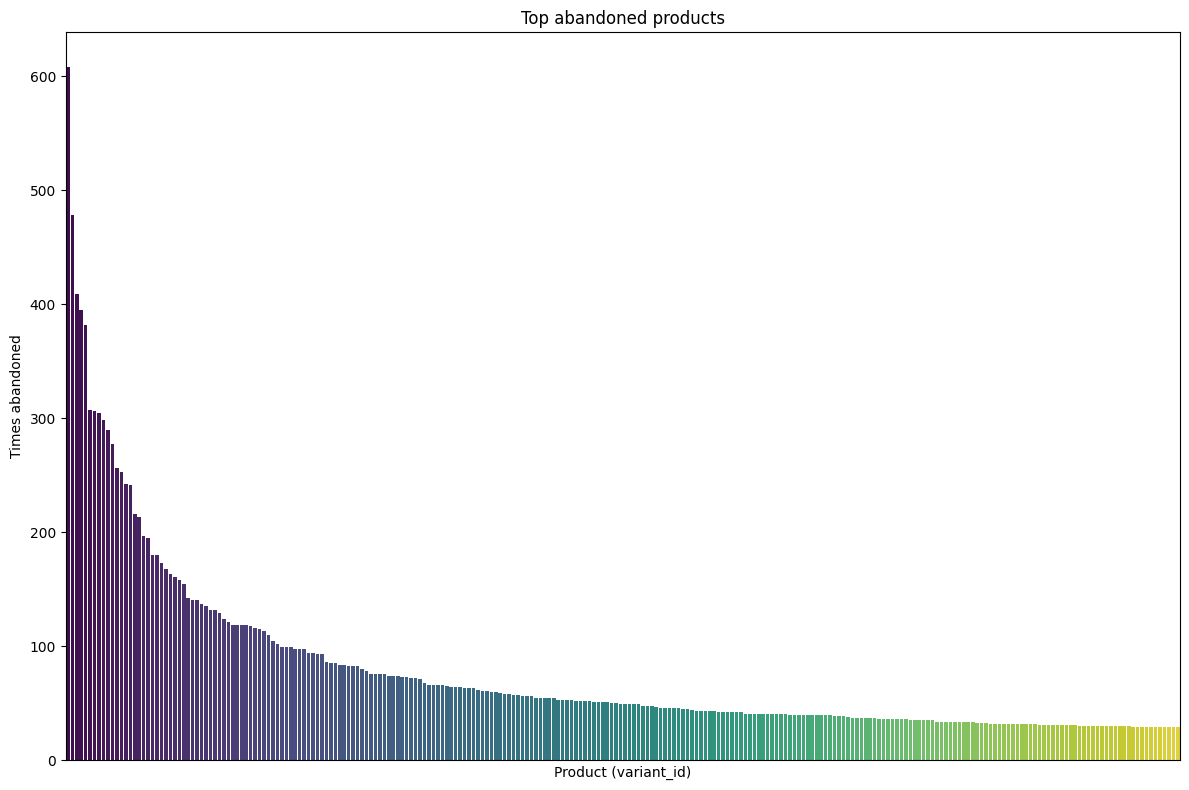

In [154]:
top_abandoned_products = abandoned_product_counts.head(250)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='variant_id', 
    y='Frequency', 
    data=top_abandoned_products, 
    palette='viridis',
    order=top_abandoned_products['variant_id']
)


plt.title('Top abandoned products')
plt.xlabel('Product (variant_id)')
plt.ylabel('Times abandoned')
plt.xticks([])
plt.tight_layout()
plt.show()

In [140]:
#Complete abandoned_product_counts dataframe with information from inventory
combined_abandoned_df = pd.merge(
    abandoned_product_counts,          
    inventory_df,           
    on='variant_id',         
    how='left'              
)

combined_abandoned_df.head()

,variant_id,Frequency,price,compare_at_price,vendor,product_type,tags
0,34081589887108,608,10.79,11.94,oatly,long-life-milk-substitutes,"[oat-milk, vegan]"
1,34284951863428,478,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
2,34284950356100,409,1.99,3.00,fairy,dishwashing,"[discontinue, swapped, washing-up-liquid]"
3,34137590366340,395,NaN,NaN,NaN,NaN,NaN
4,34284949766276,382,8.49,9.00,andrex,toilet-roll-kitchen-roll-tissue,[toilet-rolls]


In [155]:
#users with most abandoned_carts
users_abandoned_carts = abandoned_carts_df['user_id'].value_counts().reset_index()
users_abandoned_carts.columns=['user_id', 'abandoned_carts_count']

users_path = '/home/alex/zriveAM/zrive-ds/aws/data/users.parquet'
users_df = pd.read_parquet(users_path)

combined_users_abandoned_carts = pd.merge(
    users_abandoned_carts,
    users_df,
    on='user_id',
    how='left'
)

combined_users_abandoned_carts.head()


,user_id,abandoned_carts_count,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
0,257be7ae940425880bbb20bf162c2616b32881bf0a8bda4e4ce7f5ce0356c29b06e032dd593030a460d20c71353737305e51431a7df58ea0284c67c95084a42b,10,Top Up,UKI,2021-06-10 15:00:55,2021-06-01 00:00:00,4.0,2.0,2.0,0.0,0.0
1,1dacfd2a360677052d8605f843ae410dd23b0ddb7f506cc447fa78ee26bb7182ea72a8107f16633ac611c1142e90dd47d4afec7f6374b8d7b1a29492d37dd51a,9,Proposition,UKG,2021-08-06 09:23:27,2021-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2,fffd9f989509e36d1fc3e3e53627d6341482f385052a034a897249a5455c66475dfc78fc8eec13b742ada69537b20dc5b24cc59864ee21c50816f1131cf10527,7,Top Up,UKF,2021-10-21 18:17:53,2021-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
3,a8ea4d1ff9cfc5005b7354d1d17564347dd842bab2a6c39a52301046e9104a2819f65f03343f0e92a7a20cc8f1cc29d0fcf614a0f9601064b9fc684b0a908728,7,Top Up,UKF,2022-01-31 21:11:09,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4,97e81469f5758878f4d7eaa3af6b4fc37b2b5c2255881189c9bc6b4e7a2f2b63ac0c376b6116046cae8f6abc9a25f5eb28204a58c92f7e16635781cb216aa755,7,Proposition,UKK,2021-11-19 21:02:15,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [149]:
abandoned_carts_df['day_of_week'] = abandoned_carts_df['created_at'].dt.day_name()
abandonment_by_day = abandoned_carts_df['day_of_week'].value_counts().sort_values(ascending=False)

print("Abandonments by day of the week:")
print(abandonment_by_day)

Abandonments by day of the week:
day_of_week
Friday       882
Wednesday    851
Tuesday      824
Thursday     781
Monday       734
Saturday     698
Sunday       687
Name: count, dtype: int64


### Problems & rework

* As in the previous analysis,problem of variant_ids not registered in the inventory
* Multiple users with no information on the count_people, count_adults, count_children... columns

# ***Inventory data***

* Price and compare_at_price distribution

* Find products without price and without discount

* Top vendors

* Top product type

* Top tags

In [204]:
inventory_path = '/home/alex/zriveAM/zrive-ds/aws/data/inventory.parquet'
inventory_df = pd.read_parquet(inventory_path)
inventory_df.head(10)

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]
5,34460976447620,2.79,2.85,carex,hand-soap-sanitisers,"[hand-soap, refills]"
6,33667202121860,8.99,12.55,ecover,washing-liquid-gel,"[cruelty-free, eco, vegan, washing-liquid-gel]"
7,39478260695172,1.99,2.00,napolina,cooking-sauces,"[pasta-pizza-sauce, vegan]"
8,39772627533956,1.99,2.30,thepinkstuff,cleaning-products,"[all-purpose-cleaner, vegan]"
9,39887964766340,2.59,2.69,profusion,tins-packaged-foods,"[gluten-free, meat-alternatives, organic, vegan]"


In [165]:
print("Dataframe shape:", inventory_df.shape)
print("----------------------------------")
print("Dataframe info:")
print(inventory_df.info())
print("----------------------------------")
print("Statistical info")
print(inventory_df.describe())


Dataframe shape: (1733, 6)
----------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB
None
----------------------------------
Statistical info
         variant_id        price  compare_at_price
count  1.733000e+03  1733.000000       1733.000000
mean   3.694880e+13     6.307351          7.028881
std    2.725674e+12     7.107218          7.660542
min    3.361529e+13     0.000000          0.000000
25%    3.427657e+13     2.490000          2.850000
50%    3.92726

In [210]:
inventory_df = pd.read_parquet(inventory_path)
inventory_df['discount']=inventory_df['compare_at_price'] - inventory_df['price']
inventory_df=inventory_df[['variant_id', 'price', 'compare_at_price','discount', 'vendor', 'product_type', 'tags']]
print('Total items:', len(inventory_df))
print(inventory_df.head())
print("--------------------------------")

no_price_products_df=inventory_df[inventory_df['compare_at_price'] == 0]
print("Items without price:", len(no_price_products_df))
print(no_price_products_df.head())
print("--------------------------------")

#delete this rows
inventory_df = inventory_df[inventory_df['compare_at_price'] != 0]
print('Total items with price:', len(inventory_df))
print(inventory_df.head())
print("--------------------------------")

zero_discount_df= inventory_df[inventory_df['discount'] == 0]
print('Items with zero discount:', len(zero_discount_df))
print(zero_discount_df.head())

Total items: 1733
       variant_id  price  compare_at_price  discount          vendor                     product_type                                        tags
0  39587297165444   3.09              3.15      0.06           heinz             condiments-dressings                       [table-sauces, vegan]
1  34370361229444   4.99              5.50      0.51   whogivesacrap  toilet-roll-kitchen-roll-tissue                 [b-corp, eco, toilet-rolls]
2  34284951863428   3.69              3.99      0.30          plenty  toilet-roll-kitchen-roll-tissue                              [kitchen-roll]
3  33667283583108   1.79              1.99      0.20  thecheekypanda  toilet-roll-kitchen-roll-tissue  [b-corp, cruelty-free, eco, tissue, vegan]
4  33803537973380   1.99              2.09      0.10         colgate                           dental                        [dental-accessories]
--------------------------------
Items without price: 72
         variant_id  price  compare_at_price  dis

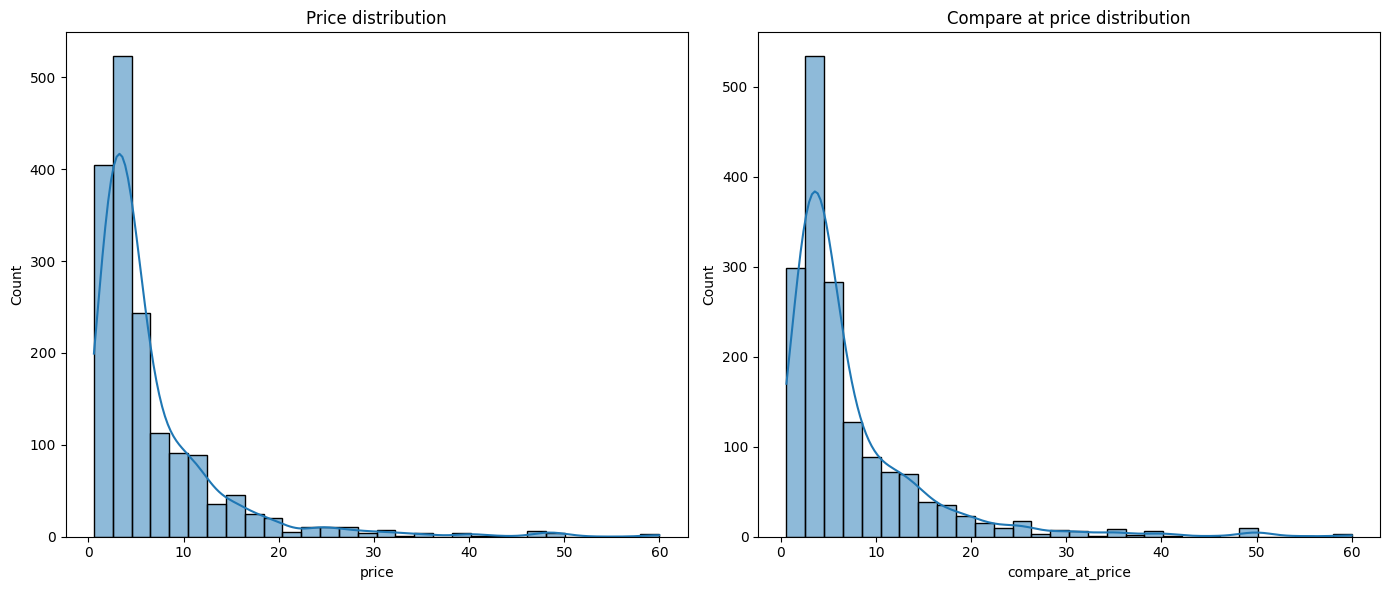

In [211]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.histplot(inventory_df['price'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Price distribution')

sns.histplot(inventory_df['compare_at_price'].dropna(), bins=30, kde=True, ax=axes[1])
axes[1].set_title('Compare at price distribution')

plt.tight_layout()
plt.show()

In [212]:
top_vendors=inventory_df['vendor'].value_counts().reset_index()
top_vendors.columns=['vendor', 'count']
top_vendors.head(15)

,vendor,count
0,biona,58
1,ecover,34
2,faithinnature,27
3,method,26
4,hiderfoods,24
5,greencuisine,24
6,various,23
7,napolina,19
8,ellaskitchen,18
9,febreze,17


In [213]:
top_products=inventory_df['product_type'].value_counts().reset_index()
top_products.columns=['product_type', 'count']
top_products.head(15)

,product_type,count
0,cleaning-products,154
1,tins-packaged-foods,112
2,snacks-confectionery,110
3,cooking-ingredients,73
4,pasta-rice-noodles,64
5,baby-toddler-food,62
6,condiments-dressings,52
7,haircare,50
8,cereal,49
9,soft-drinks-mixers,48


In [214]:
all_tags = inventory_df['tags'].explode()
tag_frequency = all_tags.value_counts().reset_index()
tag_frequency.columns = ['tag', 'count']
tag_frequency.head(10)

,tag,count
0,vegan,673
1,gluten-free,299
2,eco,285
3,cruelty-free,208
4,organic,170
5,b-corp,144
6,discontinue,114
7,christmas,108
8,refills,101
9,pm,68


These are the core of our sells (in quantity), maybe not in revenue

### Problems & rework

* Items that have not price (I have deleted them, I imagine that this is because at the moment these products aren't available, so it's not giving us information)

# ***Users data***

In [128]:
users_path = '/home/alex/zriveAM/zrive-ds/aws/data/users.parquet'
users_df = pd.read_parquet(users_path)
users_df.head(5)

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a962aa3d39097d41d37b01d5089f13306c248e66a110da986a44448c007ce8e1052db8d1802f00fbd85,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f65f3d519b46bc97b938812e4cea840a67b82c9ff349f086af76b5ba8171c0866103b942061d74027b1,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b93249db254a5f358ed7c17e47bebe76903b28447ece00be7e266aad036337cdf46ccdd9ab485136d40b85d,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c354dd736bd34eca7eb4e588c5afea0af0bf3ee41290630bcdc6042b6fae0c19428d887b586a719825bda,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec007b214d1039e959eca61c2b5bd6dc5cc09b8147f3581366413cf9ca901906969ba6c152e44ab4cd8fb1,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


Este dataframe es el que más variables incluye y haya que explicar significados:

* user_id: id del cliente

* user_segment: algún tipo de distintivo de clientes (top up y proposition)

* user_nuts1: region de uk (UKH - East of England, UKD - North West England, ec)

* first _ordered_at: Fecha exacta primer pedido (día, mes y año)

* customer_cohort_month: Mes y año de primer pedido (hacer cohorts para estudiar grupos con mismo mes y año)

* count_people: numero de personas asociadas al id

* count_adults: numero de adultos asociados al id

* count_children: numero de niños asociados al id

* count_babies: numero de bebés asociados al id

* count_pets: numero de mascotas asociados al id

In [129]:
print("Dataframe shape:", users_df.shape)
print("----------------------------------")
print("Dataframe info:")
print(users_df.info())
print("----------------------------------")
print("Null values:")
print(users_df.isnull().sum())


Dataframe shape: (4983, 10)
----------------------------------
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB
None
----------------------------------
Null values:
user_id                     0
user_segment                0
user_nuts1               

In [130]:
users_df['user_segment'].value_counts()

user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64

In [131]:
users_df['count_people'].value_counts()

count_people
2.0    97
3.0    68
4.0    67
1.0    57
5.0    24
6.0     8
0.0     2
7.0     1
8.0     1
Name: count, dtype: int64

In [132]:
feature_frame_path = '/home/alex/zriveAM/zrive-ds/aws/data/feature_frame.csv'
feature_frame_df = pd.read_csv(feature_frame_path)
print(feature_frame_df.shape)

(2880549, 27)
